In [65]:
import obspy
import theano
import instaseis
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import theano.tensor as tt
import pymc

from obspy.taup import TauPyModel
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach,beachball
from theano import shared

%matplotlib inline

In [66]:
db = instaseis.open_db("./databases/20s_PREM_ANI_FORCES")
prem = TauPyModel('prem')

In [67]:
def forward_model(source,receiver,taup_model,t_start,t_end,phase='P',arr=None,return_stream=False):
    '''
    positional arguments
    source: instaseis source object
    receiver: instaseis receiver object
    taup_model: a TauPyModel object used to calculate travel times
    t_start: start time (in s) relative to phase arrival
    t_end: end time (in s) relative to phase arrival

    
    optional aguments
    phase: phase to window seismogram around (defaults to P)
    return_stream: if True, returns both the data vector and a three component (RTZ) obspy stream
    arr: an obspy taup arrival object. If none is provided, the travel time will be calculated.
    
    '''
    
    st = db.get_seismograms(source=source, receiver=receiver,components='RTZ',kind='displacement')
    if arr == None:
        phase_arrs = taup_model.get_travel_times_geo(source_depth_in_km=source.depth_in_m/1000.0, 
                                                     source_latitude_in_deg=source.latitude,
                                                     source_longitude_in_deg=source.longitude, 
                                                     receiver_latitude_in_deg=receiver.latitude,
                                                     receiver_longitude_in_deg=receiver.longitude,
                                                     phase_list=[phase])
        arr = phase_arrs[0]
        
    st_new = obspy.Stream()
    for tr in st:
        starttime = tr.stats.starttime + arr.time + t_start
        endtime = tr.stats.starttime + arr.time + t_end
        windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
        st_new += windowed_tr
        
    st = st_new
    st.sort()
    data_vector = np.hstack((st[0].data,st[1].data,st[2].data))
    
    if return_stream:
        return data_vector,st
    else:
        return data_vector

In [68]:
@theano.compile.ops.as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar],
                          otypes=[tt.dvector])
def gen_data(m_rr,m_tt,m_pp,m_rt,m_rp,m_tp):

    source_est = instaseis.Source(
                 latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
                 m_rr = float(m_rr),
                 m_tt = float(m_tt),
                 m_pp = float(m_pp),
                 m_rt = float(m_rt),
                 m_rp = float(m_rp),
                 m_tp = float(m_tp),
                 origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    
    receiver = instaseis.Receiver(
               latitude=rec_lat, 
               longitude=rec_lon, 
               network="US", 
               station="AAM")
    
    t_start = -20.0
    t_end = 250.0
    arr_time = 88.355
    
    st = db.get_seismograms(source=source_est, receiver=receiver,components='RTZ',kind='displacement')
    st_new = obspy.Stream()
    
    for tr in st:
        starttime = tr.stats.starttime + arr_time + t_start
        endtime = tr.stats.starttime + arr_time + t_end
        windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
        st_new += windowed_tr
        
    st = st_new
    st.sort()
    data_vector = np.hstack((st[0].data,st[1].data,st[2].data))

    return data_vector

In [69]:
class geo_synthesizer(theano.Op):
    # Properties attribute
    __props__ = ()

    #itypes and otypes attributes are
    #compulsory if make_node method is not defined.
    #They're the type of input and output respectively
    itypes = [tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar]
    otypes = [tt.dvector]

    #Compulsory if itypes and otypes are not defined
    #def make_node(self, inputs):
        
    #   pass

    # Python implementation:
    #def perform(self, node, inputs, output):
    def perform(self, inputs, outputs):
        source_est = instaseis.Source(
                     latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
                     m_rr = float(m_rr),
                     m_tt = float(m_tt),
                     m_pp = float(m_pp),
                     m_rt = float(m_rt),
                     m_rp = float(m_rp),
                     m_tp = float(m_tp),
                     origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    
        receiver = instaseis.Receiver(
                   latitude=rec_lat, 
                   longitude=rec_lon, 
                   network="US", 
                   station="AAM")
    
        t_start = -20.0
        t_end = 250.0
        arr_time = 88.355
    
        st = db.get_seismograms(source=source_est, receiver=receiver,components='RTZ',kind='displacement')
        st_new = obspy.Stream()
    
        for tr in st:
            starttime = tr.stats.starttime + arr_time + t_start
            endtime = tr.stats.starttime + arr_time + t_end
            windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
            st_new += windowed_tr
        
        st = st_new
        st.sort()
        data_vector = np.hstack((st[0].data,st[1].data,st[2].data))

        return data_vector

### Generate 'true' synthetic data

In [70]:
#define 'true' source parameters
normalize_factor = 1e17
m_rr_true = 4.710000e+17 / normalize_factor
m_tt_true = 3.810000e+15 / normalize_factor
m_pp_true = -4.740000e+17 / normalize_factor
m_rt_true = 3.990000e+16 / normalize_factor
m_rp_true = -8.050000e+16 / normalize_factor
m_tp_true = -1.230000e+17 / normalize_factor
lon_true = -77.93
lat_true = 37.91
depth_true = 12000.
mt_true = [m_rr_true,m_tt_true,m_pp_true,m_rt_true,m_rp_true,m_tp_true]

#define receiver parameters
rec_lon = -83.66
rec_lat = 42.3 

#make instaseis Source and Receiver objects
source_true = instaseis.Source(
    latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
    m_rr = m_rr_true,
    m_tt = m_tt_true,
    m_pp = m_pp_true,
    m_rt = m_rt_true,
    m_rp = m_rp_true,
    m_tp = m_tp_true,
    origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
print source_true
receiver = instaseis.Receiver(
    latitude=rec_lat, 
    longitude=rec_lon, 
    network="US", 
    station="AAM")

#calculate expected P arrival
phase_arrs = prem.get_travel_times_geo(source_depth_in_km=source_true.depth_in_m/1000.0, 
                                       source_latitude_in_deg=source_true.latitude,
                                       source_longitude_in_deg=source_true.longitude, 
                                       receiver_latitude_in_deg=receiver.latitude,
                                       receiver_longitude_in_deg=receiver.longitude,
                                       phase_list=['P'])
P_arr = phase_arrs[0]
print P_arr

#get synthetic data vector, and seismograms
data_true,st_true = forward_model(source_true,receiver,taup_model=prem,
                                  t_start=-20.,t_end=250.,arr=P_arr,return_stream=True)




Instaseis Source:
	Origin Time      : 2011-08-23T17:51:03.000000Z
	Longitude        :  -77.9 deg
	Latitude         :   37.9 deg
	Depth            : 1.2e+01 km km
	Moment Magnitude :   -5.60
	Scalar Moment    :   4.96e+00 Nm
	Mrr              :   4.71e+00 Nm
	Mtt              :   3.81e-02 Nm
	Mpp              :  -4.74e+00 Nm
	Mrt              :   3.99e-01 Nm
	Mrp              :  -8.05e-01 Nm
	Mtp              :  -1.23e+00 Nm

P phase arrival at 88.355 seconds


### Plot 'true' synthetic data

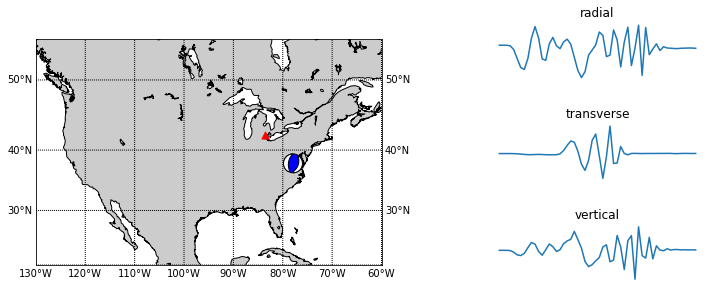

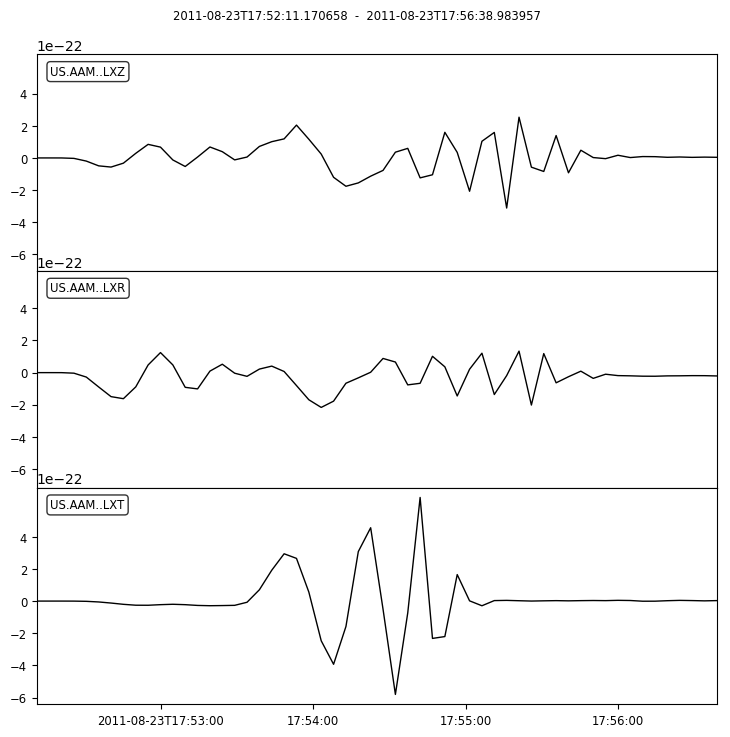

In [71]:
#plot map and 'true' (synthetic) data
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-130.,llcrnrlat=20.,urcrnrlon=-60.,urcrnrlat=55.,\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(np.arange(10,90,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,10),labels=[1,1,0,1])
x, y = m(lon_true, lat_true)
#ax = plt.gca()
b = beach(mt_true, xy=(x, y), width=400000, linewidth=1, alpha=1.0)
b.set_zorder(10)
ax.add_collection(b)
x, y = m(rec_lon, rec_lat)
ax.scatter(x,y,marker='^',color='r',s=50,zorder=99)

#plot_waveforms
#radial
ax_r=fig.add_axes([1.15,0.75,0.5,0.2])
ax_r.plot(st_true[0].data)
ax_r.set_title('radial')
ax_r.set_axis_off()
ax_t=fig.add_axes([1.15,0.4,0.5,0.2])
ax_t.plot(st_true[1].data)
ax_t.set_title('transverse')
ax_t.set_axis_off()
ax_z=fig.add_axes([1.15,0.05,0.5,0.2])
ax_z.plot(st_true[2].data)
ax_z.set_title('vertical')
ax_z.set_axis_off()
plt.show()
st_true.plot()

### Define Monte Carlo model

In [72]:
with pm.Model() as model:
    m_rr = pm.Uniform('m_rr',lower=-10,upper=10)
    m_tt = pm.Uniform('m_tt',lower=-10,upper=10)
    m_pp = pm.Uniform('m_pp',lower=-10,upper=10)
    m_rt = pm.Uniform('m_rt',lower=-10,upper=10)
    m_rp = pm.Uniform('m_rp',lower=-10,upper=10)
    m_tp = pm.Uniform('m_tp',lower=-10,upper=10)
    
    #m_rr = pm.Uniform('m_rr',lower=-1e18,upper=1e18)
    #m_tt = pm.Uniform('m_tt',lower=-1e18,upper=1e18)
    #m_pp = pm.Uniform('m_pp',lower=-1e18,upper=1e18)
    #m_rt = pm.Uniform('m_rt',lower=-1e18,upper=1e18)
    #m_rp = pm.Uniform('m_rp',lower=-1e18,upper=1e18)
    #m_tp = pm.Uniform('m_tp',lower=-1e18,upper=1e18)

    #perform forward calculation
    #source_est = instaseis.Source(
    #                   latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
    #                   m_rr = m_rr,
    #                   m_tt = m_tt,
    #                   m_pp = m_pp,
    #                   m_rt = m_rt,
    #                   m_rp = m_rp,
    #                   m_tp = m_tp,
    #                   origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    
    #print receiver
    #print source_est
    
    #data_est = forward_model(source_est,receiver,taup_model=prem,
    #                        t_start=-20.,t_end=250.,arr=P_arr)
    #data_est = gen_data(m_rr,m_tt,m_pp,m_rt,m_rp,m_tp)
    
    get_synths = geo_synthesizer()
    data_est = get_synths(m_rr,m_tt,m_pp,m_rt,m_rp,m_tp)
    
    #model_error
    sigma = 1e-21
    
    #data likelihood
    y_like = pm.Normal('y_like',mu=data_est,sd=sigma,observed=data_true)
    
    #sample!
    step = pm.Metropolis()
    #step = pm.NUTS()
    trace = pm.sample(10,step)

TypeError: perform() takes exactly 3 arguments (4 given)

In [ ]:
pm.traceplot(trace)

In [ ]:
source_est = instaseis.Source(
    latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
    m_rr = 4.71,
    m_tt = 0.0381,
    m_pp = -4.74,
    m_rt = 0.399,
    m_rp = -0.805,
    m_tp = -1.23,
    origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
data_est = forward_model(source_est,receiver,taup_model=prem,
                        t_start=-20.,t_end=250.,arr=P_arr)
plt.plot(data_est)
plt.plot(data_true)
plt.show()

def likelihood(data_true,data_est,sigma=1e-4):
    misfit = np.linalg.norm(data_true - data_est)
    pdm = np.exp(-0.5*(misfit/sigma)**2)
    return pdm

likelihood(data_true,data_est,sigma=1e-21)

In [ ]:
print mt_true

In [ ]:
for i in range(0,1000):
    source_est = instaseis.Source(
            latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
            m_rr = np.random.rand(),
            m_tt = np.random.rand(),
            m_pp = np.random.rand(),
            m_rt = np.random.rand(),
            m_rp = np.random.rand(),
            m_tp = np.random.rand(),
            origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    data_true,st_true = forward_model(source_true,receiver,taup_model=prem,
                                      t_start=-20.,t_end=250.,arr=P_arr,return_stream=True)
    print i,np.random.rand()

In [ ]:
m_rt

In [ ]:
class gen_sources(theano.Op):
    '''
    Theano wrapper for generating an instaseis source of pymc3 distribution variables
    '''
    
    def __init__(self,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp,depth,lat,lon):
        self.m_rr = m_rr
        self.m_tt = m_tt
        self.m_pp = m_pp
        self.m_rt = m_rt
        self.m_rp = m_rp
        self.m_tp = m_tp
        self.depth = depth
        self.lat = lat
        self.lon = lon
        
    def get_source(self):
        source_est = instaseis.Source(
             latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
             m_rr = float(m_rr),
             m_tt = float(m_tt),
             m_pp = float(m_pp),
             m_rt = float(m_rt),
             m_rp = float(m_rp),
             m_tp = float(m_tp),
             origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
        return source_est